This Jupyter notebook can be found on my GitHub page (located at: https://github.com/djsaunde/GRiD/data_processing_tutorial)

# Processing Data with Python and Pandas

Python is a preferred language for data ingestion / munging / processing / analysis. The open-source software (OSS) ecosystem surrounding data science efforts is particularly large and thriving, which allows programmers of many skill levels to answer questions about their data without much of a headache.

Jupyter notebooks (what we are using now) are a great tool for documenting and communicating your data science pipeline. In particular, notebooks allow you to write Markdown or code alternately, and has support for over 40 languages (Python, R, Julia, Scala, ...). Check out the [Project Jupyter webpage](http://jupyter.org/) for more information and other great software.

## Imports

In [1]:
from mpl_toolkits.basemap import Basemap

import scipy
import timeit
import colorsys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

%matplotlib inline

## The data

We will use a .csv file of [NYC green taxicab trip records](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml) from January 2016. By law, all NYC taxicabs and similar transportation services (e.g., Lyft and Uber) are required to record data from every trip taken by their paid service. That's a lot of interesting information we can use to understand the hustle and bustle of data-to-day NYC!

## Loading the data

We will use `pandas`' helpful `read_csv` function in order to load the aformentioned .csv file into a `pandas DataFrame`. The `DataFrame` object is the "primitive" data structure provided by the pandas package, and most of its functionality is built around it. The file is ~220Mb in size, but luckily, as it is stored in the .csv file format (which has very little metadata), we can still read it in quickly.

__Note__: If we were to use the corresponding 1-month yellow taxicab records file (~1.3Gb), loading and subsequent processing would take a few more seconds. For the sake of this tutorial, we'll stick with the green taxicab data.

In [2]:
start_time = timeit.default_timer()

# Load in the data using the 'read_csv' function.
taxi_data = pd.read_csv('green_tripdata_2016-01.csv')
print 'It took', timeit.default_timer() - start_time, 'seconds to read in the green taxicab data.'

It took 3.26395797729 seconds to read in the green taxicab data.


## Inspecting the data

Now that we have the data in our workspace, we can make use of the Jupyter notebook interface to inspect a pretty-printed version of the `DataFrame`. This is a good time to decide whether or not your data needs _cleaning_: Are there any missing values? Is there information unneccesary for downstream processing? Are the datatypes mixed or incorrect? Using the `pandas` library, we can usually correct these on-the-fly.

In [3]:
# Pretty-prints the first 5 rows of the DataFrame.
taxi_data.head(5)

VendorID lpep_pickup_datetime Lpep_dropoff_datetime Store_and_fwd_flag  \
0         2  2016-01-01 00:29:24   2016-01-01 00:39:36                  N   
1         2  2016-01-01 00:19:39   2016-01-01 00:39:18                  N   
2         2  2016-01-01 00:19:33   2016-01-01 00:39:48                  N   
3         2  2016-01-01 00:22:12   2016-01-01 00:38:32                  N   
4         2  2016-01-01 00:24:01   2016-01-01 00:39:22                  N   

   RateCodeID  Pickup_longitude  Pickup_latitude  Dropoff_longitude  \
0           1        -73.928642        40.680611         -73.924278   
1           1        -73.952675        40.723175         -73.923920   
2           1        -73.971611        40.676105         -74.013161   
3           1        -73.989502        40.669579         -74.000648   
4           1        -73.964729        40.682854         -73.940720   

   Dropoff_latitude  Passenger_count     ...      Fare_amount  Extra  MTA_tax  \
0         40.698044                1     ...              8.0    0.5      0.5   
1         40.761379                1     ...             15.5    0.5      0.5   
2         40.646072                1     ...             16.5    0.5      0.5   
3         40.689034                1     ...             13.5    0.5      0.5   
4         40.663013                1     ...             12.0    0.5      0.5   

   Tip_amount  Tolls_amount  Ehail_fee  improvement_surcharge  Total_amount  \
0        1.86           0.0        NaN                    0.3         11.16   
1        0.00           0.0        NaN                    0.3         16.80   
2        4.45           0.0        NaN                    0.3         22.25   
3        0.00           0.0        NaN                    0.3         14.80   
4        0.00           0.0        NaN                    0.3         13.30   

   Payment_type  Trip_type   
0             1         1.0  
1             2         1.0  
2             1         1.0  
3             2         1.0  
4             2         1.0  

[5 rows x 21 columns]

## Cleaning the data

On first glance, it is clear that certain items in the `DataFrame` aren't needed for any kind of analysis we can think of. So, let's begin by deleting some unneeded variables, or columns. The choice of columns to delete is subjective; this depends on your application and what memory constraints you may be working with.

In [4]:
# What columns are there to begin with?
for idx, column in enumerate(taxi_data.columns.values):
    print idx + 1, ':', column

print '\n'

# Rename columns with odd or strangely formatted names.
taxi_data = taxi_data.rename(index=str, columns={'lpep_pickup_datetime' : 'pickup_time', \
                                    'Lpep_dropoff_datetime' : 'dropoff_time', \
                                    'Pickup_longitude' : 'pickup_longitude', \
                                    'Pickup_latitude' : 'pickup_latitude', \
                                    'Dropoff_longitude' : 'dropoff_longitude', \
                                    'Dropoff_latitude' : 'dropoff_latitude', \
                                    'Passenger_count' : 'passengers', \
                                    'Trip_distance' : 'distance', \
                                    'Fare_amount' : 'fare', \
                                    'Tip_amount' : 'tip'})

# Select only the columns for downstream processing.
interesting_columns = ['pickup_time', 'dropoff_time', 'pickup_longitude', 'pickup_latitude', \
                'dropoff_longitude', 'dropoff_latitude', 'passengers', 'distance', 'fare', 'tip']
taxi_data = taxi_data[interesting_columns]

m = Basemap(projection='hammer', llcrnrlon=-74.025, llcrnrlat=40.63, urcrnrlon=-73.76, urcrnrlat=40.85, epsg=4269)

# Remove all taxi rides which don't begin or end within New York City
taxi_data = taxi_data[(taxi_data['pickup_longitude'] >= -74.025) & (taxi_data['pickup_longitude'] <= -73.76) & \
                     (taxi_data['dropoff_longitude'] >= -74.025) & (taxi_data['dropoff_longitude'] <= -73.76) & \
                     (taxi_data['pickup_latitude'] >= 40.63) & (taxi_data['pickup_latitude'] <= 40.85) & \
                     (taxi_data['dropoff_latitude'] >= 40.63) & (taxi_data['dropoff_latitude'] <= 40.85)]

# Which columns remain?
for idx, column in enumerate(taxi_data.columns.values):
    print idx + 1, ':', column

1 : VendorID
2 : lpep_pickup_datetime
3 : Lpep_dropoff_datetime
4 : Store_and_fwd_flag
5 : RateCodeID
6 : Pickup_longitude
7 : Pickup_latitude
8 : Dropoff_longitude
9 : Dropoff_latitude
10 : Passenger_count
11 : Trip_distance
12 : Fare_amount
13 : Extra
14 : MTA_tax
15 : Tip_amount
16 : Tolls_amount
17 : Ehail_fee
18 : improvement_surcharge
19 : Total_amount
20 : Payment_type
21 : Trip_type 


1 : pickup_time
2 : dropoff_time
3 : pickup_longitude
4 : pickup_latitude
5 : dropoff_longitude
6 : dropoff_latitude
7 : passengers
8 : distance
9 : fare
10 : tip


In [5]:
# Pretty-prints the first 5 rowso of the DataFrame.
taxi_data.head(5)

pickup_time         dropoff_time  pickup_longitude  \
0  2016-01-01 00:29:24  2016-01-01 00:39:36        -73.928642   
1  2016-01-01 00:19:39  2016-01-01 00:39:18        -73.952675   
2  2016-01-01 00:19:33  2016-01-01 00:39:48        -73.971611   
3  2016-01-01 00:22:12  2016-01-01 00:38:32        -73.989502   
4  2016-01-01 00:24:01  2016-01-01 00:39:22        -73.964729   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passengers  distance  \
0        40.680611         -73.924278         40.698044           1      1.46   
1        40.723175         -73.923920         40.761379           1      3.56   
2        40.676105         -74.013161         40.646072           1      3.79   
3        40.669579         -74.000648         40.689034           1      3.01   
4        40.682854         -73.940720         40.663013           1      2.55   

   fare   tip  
0   8.0  1.86  
1  15.5  0.00  
2  16.5  4.45  
3  13.5  0.00  
4  12.0  0.00

## Data analysis

Let's calculate and display some statistics on our dataset.

In [6]:
print '- Number of observations (datapoints) in the dataset:', len(taxi_data.index), '\n'
print '- Mean pickup (latitude, longitude):\n', taxi_data[['pickup_latitude', 'pickup_longitude']].mean(axis=0), '\n'
print '- Mean dropoff (latitude, longitude):\n', taxi_data[['dropoff_latitude', 'dropoff_longitude']].mean(axis=0), '\n'
print '- Mean distance traveled (in miles):', taxi_data['distance'].mean(), '\n'
print '- Mean fare:', taxi_data['fare'].mean(), '\n'
print '- Mean tip:', taxi_data['tip'].mean(), '\n'
print '- Mean number of passengers:', taxi_data['passengers'].mean(), '\n'

- Number of observations (datapoints) in the dataset: 1348808 

- Mean pickup (latitude, longitude):
pickup_latitude     40.743639
pickup_longitude   -73.937508
dtype: float64 

- Mean dropoff (latitude, longitude):
dropoff_latitude     40.741702
dropoff_longitude   -73.936702
dtype: float64 

- Mean distance traveled (in miles): 2.61967648472 

- Mean fare: 11.5347537307 

- Mean tip: 1.23892296012 

- Mean number of passengers: 1.3653055142 



Let's go one step further, and plot distributions (binned histograms) of some of these quantities.

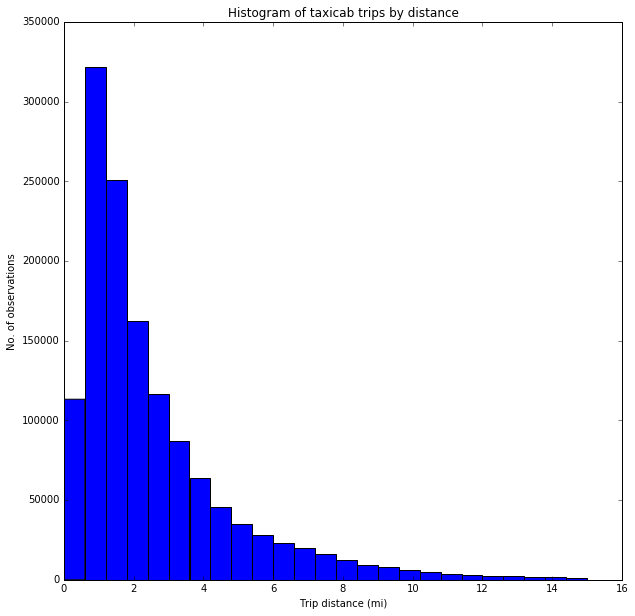

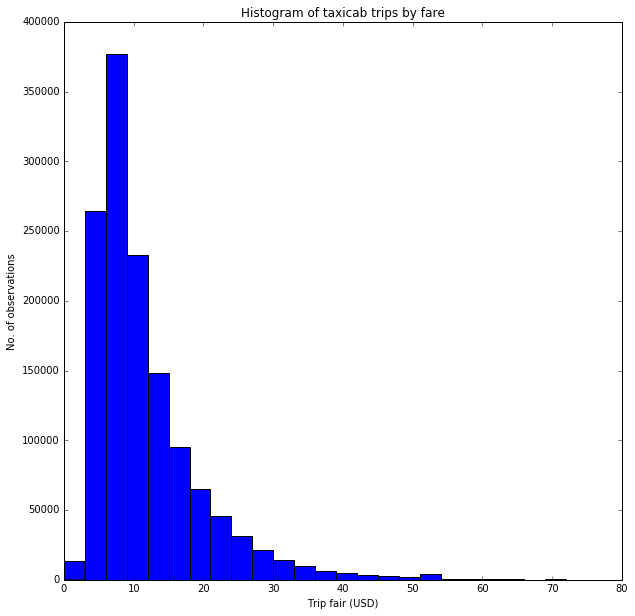

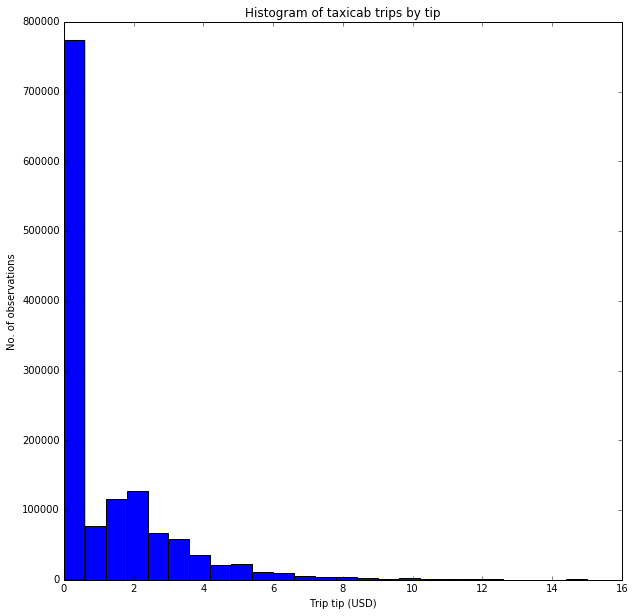

In [7]:
plt.rcParams['figure.figsize'] = (10, 10)

plt.hist(taxi_data['distance'], bins=25, range=[0, 15]); plt.xlabel('Trip distance (mi)')
plt.ylabel('No. of observations'); plt.title('Histogram of taxicab trips by distance')
plt.show()

plt.hist(taxi_data['fare'], bins=25, range=[0, 75]); plt.xlabel('Trip fair (USD)')
plt.ylabel('No. of observations'); plt.title('Histogram of taxicab trips by fare')
plt.show()

plt.hist(taxi_data['tip'], bins=25, range=[0, 15]); plt.xlabel('Trip tip (USD)')
plt.ylabel('No. of observations'); plt.title('Histogram of taxicab trips by tip')
plt.show()

For kicks, let's take a look at a sample of 25,000 taxicab pick-up locations on a map of New York City. Here, we use `matplotlib.basemap.Basemap` in combination with the ArcGIS service ([webpage](https://www.arcgis.com/features/index.html)) in order to make the plots on a background of New York City.

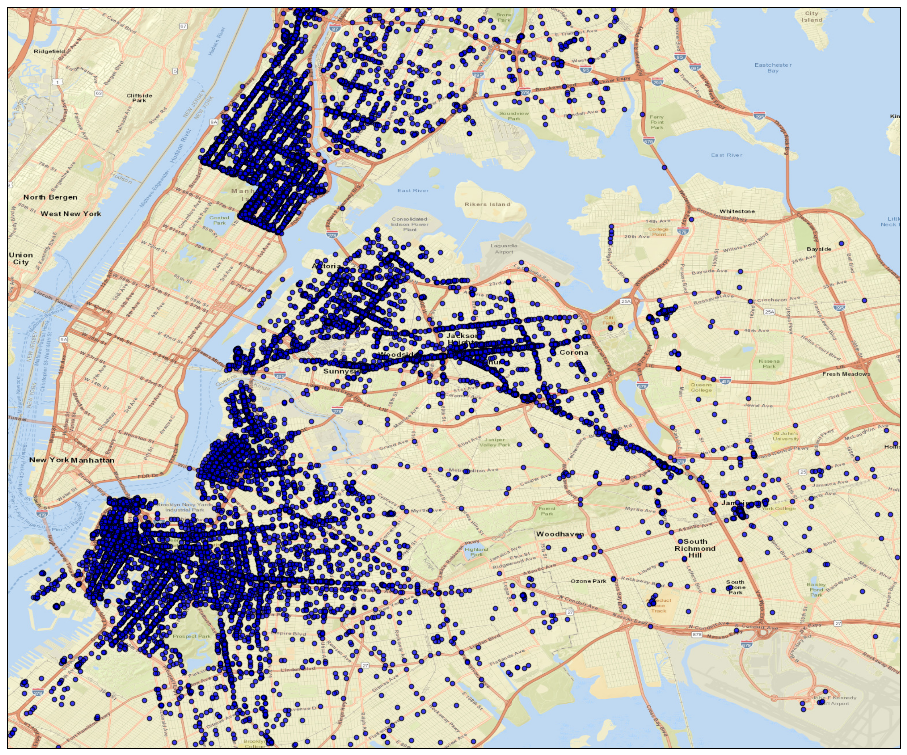

In [8]:
plt.rcParams["figure.figsize"] = (16, 16)

m = Basemap(projection='hammer', llcrnrlon=-74.025, llcrnrlat=40.63, urcrnrlon=-73.76, urcrnrlat=40.85, epsg=4269)
m.arcgisimage(service='World_Street_Map', xpixels=2000, dpi=400)

samples = np.random.choice(taxi_data.index, 25000, replace=False)

plt.scatter(taxi_data['pickup_longitude'][samples], taxi_data['pickup_latitude'][samples], c='b', alpha=0.75)
plt.show()

As you can see, __green taxis don't venture into south Manhattan to pick up customers__. Why? Well, that area is considered the turf of the yellow taxicabs ([source](http://www.nyc.gov/html/tlc/html/passenger/shl_passenger.shtml)).

Now, let's look at the drop-off locations of those same 25,000 samples.

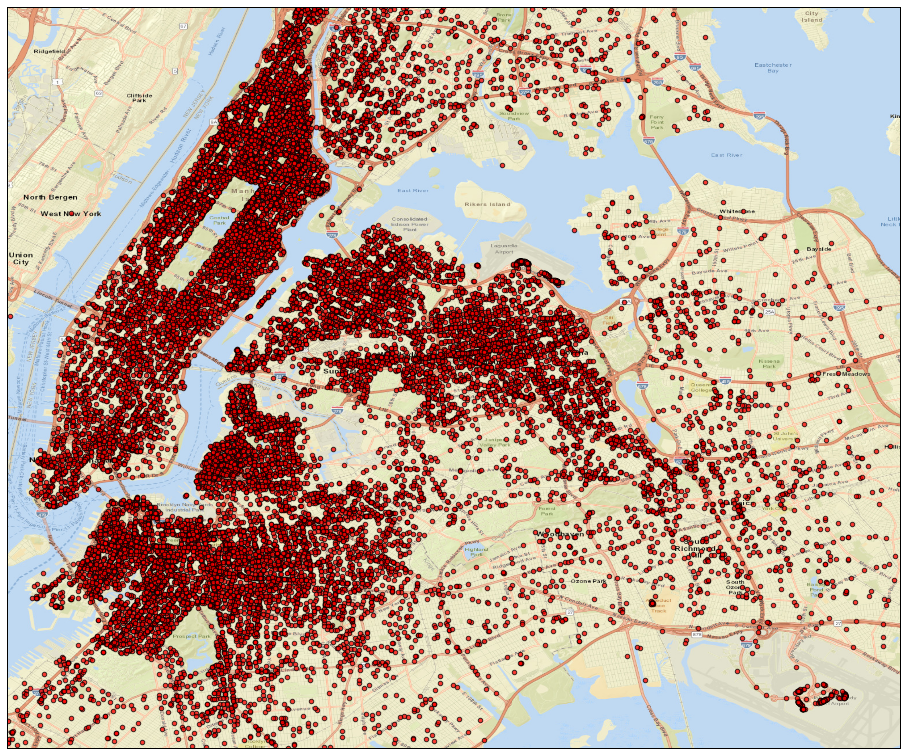

In [9]:
m = Basemap(projection='hammer', llcrnrlon=-74.025, llcrnrlat=40.63, urcrnrlon=-73.76, urcrnrlat=40.85, epsg=4269)
m.arcgisimage(service='World_Street_Map', xpixels=2000, dpi=400)

samples = np.random.choice(taxi_data.index, 25000, replace=False)

plt.scatter(taxi_data['dropoff_longitude'][samples], taxi_data['dropoff_latitude'][samples], c='r', alpha=0.75)
plt.show()

You'll notice that the geospatial distribution of these rides is much more spread, and covers the entirety of Manhattan instead of just the northern part.

Let's cluster the pick-up locations, and try to make sense of where green taxicabs get most of their business from.

In [10]:
sample_pickups = np.array(zip(taxi_data['pickup_longitude'][samples], taxi_data['pickup_latitude'][samples]))
n_clusters = 15 # How many clusters to use.
model = KMeans(n_clusters=n_clusters).fit(sample_pickups)

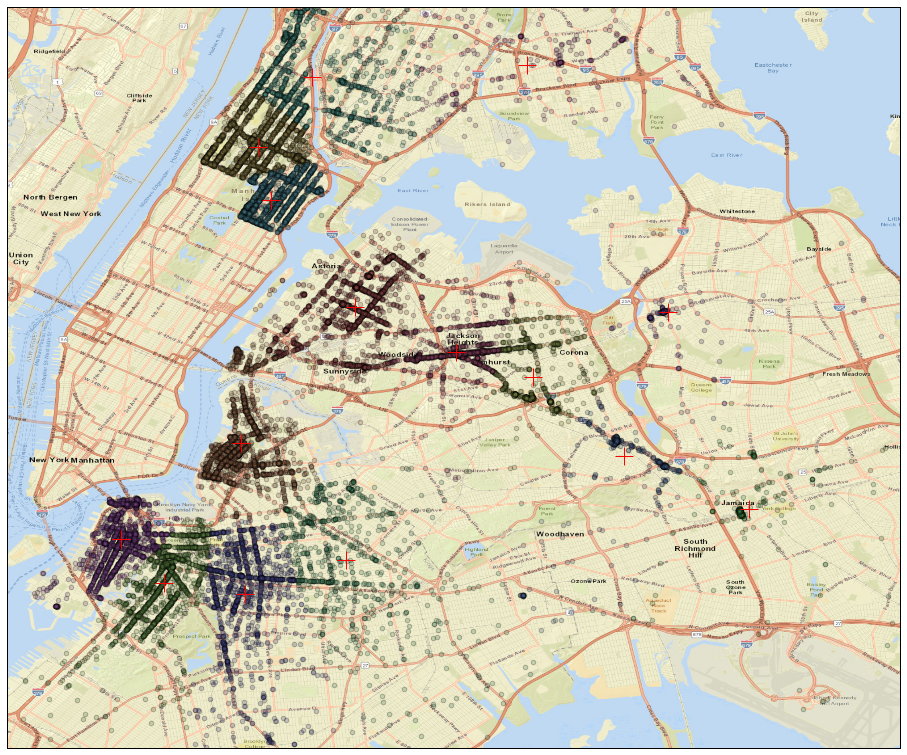

In [11]:
m = Basemap(projection='hammer', llcrnrlon=-74.025, llcrnrlat=40.63, urcrnrlon=-73.76, urcrnrlat=40.85, epsg=4269)
m.arcgisimage(service='World_Street_Map', xpixels=2000, dpi=400)

# Get the (longitude, latitude) coordinates of the cluster centers found by the KMeans algorithm.
cluster_longitudes, cluster_latitudes = model.cluster_centers_[:, 0], model.cluster_centers_[:, 1]

# Get 'n_clusters' distinct colors for visualizing clusters.
HSVs = [(x*1.0/n_clusters, 0.5, 0.5) for x in range(n_clusters)]
RGBs = map(lambda x: colorsys.hsv_to_rgb(*x), HSVs)

# Plot each group of taxicab pickups in turn by cluster identity.
for idx in xrange(n_clusters):
    plt.scatter(taxi_data['pickup_longitude'][samples][model.labels_ == idx], \
        taxi_data['pickup_latitude'][samples][model.labels_ == idx], c=RGBs[idx], alpha=0.25)

plt.scatter(cluster_longitudes, cluster_latitudes, s=300, marker='+', c='r')
plt.show()

Now that we have a clustering of this month's taxicab pickup locations and have visualized it on our map of NYC, let's calculate some quantities of interest per cluster. For example, based on which cluster we are located in, what is the average value of the cab fare?

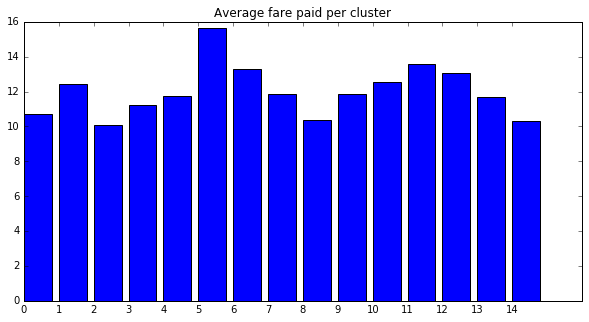

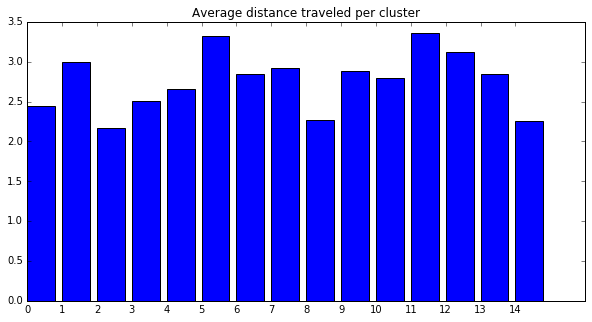

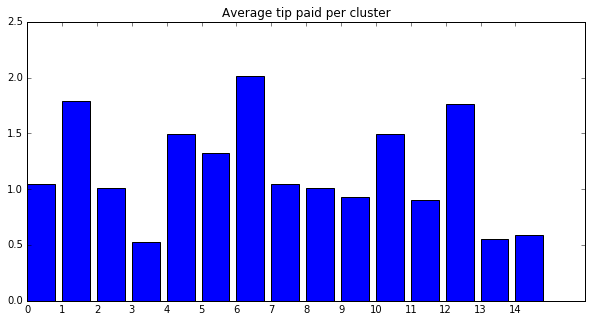

In [12]:
plt.rcParams["figure.figsize"] = (10, 5)

# Get the fares from the taxicab trips previously sampled from the entire data.
fare_samples = np.array(taxi_data['fare'][samples])

average_fares = []
# Loop through each cluster by index.
for cluster_idx in xrange(n_clusters):
    # Calculate the average value of the fare based on the cluster index.
    average_fares.append(np.mean(fare_samples[np.where(model.labels_ == cluster_idx)]))

plt.bar(xrange(n_clusters), average_fares), plt.xticks(xrange(n_clusters))
plt.title('Average fare paid per cluster')
plt.show()

# Get the distances from the taxicab trips previously sampled from the entire data.
distance_samples = np.array(taxi_data['distance'][samples])

average_distances = []
# Loop through each cluster by index.
for cluster_idx in xrange(n_clusters):
    # Calculate the average value of the distance based on the cluster index.
    average_distances.append(np.mean(distance_samples[np.where(model.labels_ == cluster_idx)]))

plt.bar(xrange(n_clusters), average_distances), plt.xticks(xrange(n_clusters))
plt.title('Average distance traveled per cluster')
plt.show()

# Get the tips from the taxicab trips previously sampled from the entire data.
tip_samples = np.array(taxi_data['tip'][samples])

average_tips = []
# Loop through each cluster by index.
for cluster_idx in xrange(n_clusters):
    # Calculate the average value of the tip based on the cluster index.
    average_tips.append(np.mean(tip_samples[np.where(model.labels_ == cluster_idx)]))

plt.bar(xrange(n_clusters), average_tips), plt.xticks(xrange(n_clusters))
plt.title('Average tip paid per cluster')
plt.show()

Since the average values of the tips per cluster seem the most variable, let's plot these values on the map of New York City along with text annotations with the average tip on the cluster centers. 

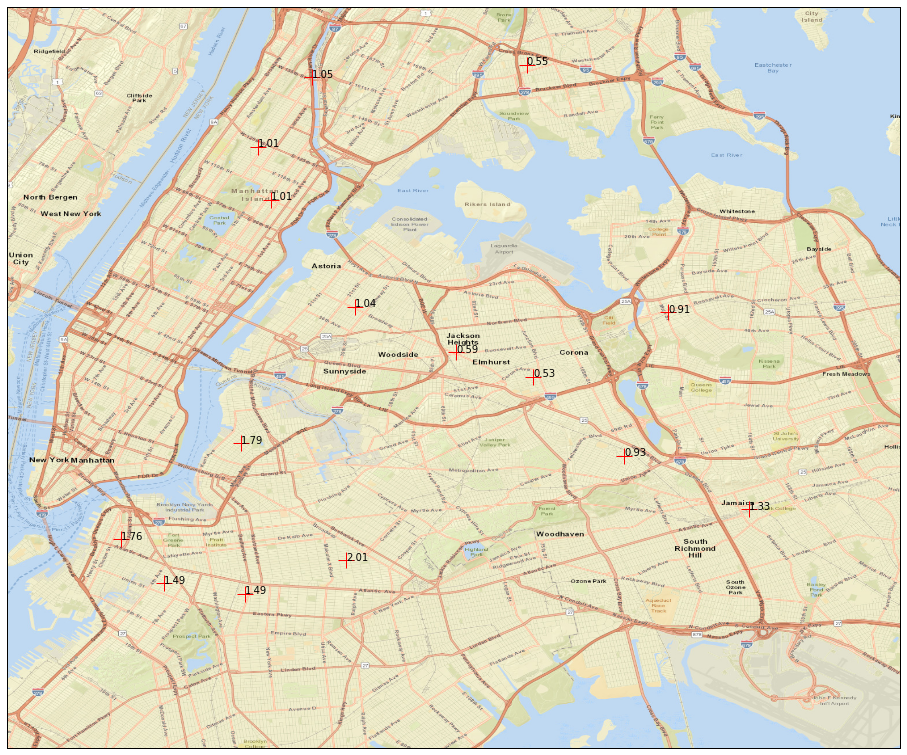

In [13]:
plt.rcParams["figure.figsize"] = (16, 16)

m = Basemap(projection='hammer', llcrnrlon=-74.025, llcrnrlat=40.63, urcrnrlon=-73.76, urcrnrlat=40.85, epsg=4269)
m.arcgisimage(service='World_Street_Map', xpixels=2000, dpi=400)

# Plot each group of taxicab pickups in turn by cluster identity.
# for idx in xrange(n_clusters):
#     plt.scatter(taxi_data['pickup_longitude'][samples][model.labels_ == idx], \
#         taxi_data['pickup_latitude'][samples][model.labels_ == idx], c=RGBs[idx], alpha=0.1)

# Annotate each cluster center with the average tip value.
for idx, average_tip in enumerate(average_tips):
    plt.annotate('{0:.2f}'.format(average_tip), xy=(model.cluster_centers_[idx][0], \
                                    model.cluster_centers_[idx][1]))

plt.scatter(cluster_longitudes, cluster_latitudes, s=250, marker='+', c='r')
plt.show()